## Evaluation of Stimuli pre Trial ##

In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



In [94]:
np.random.seed(42)
rng = np.random.default_rng(4203)
total_count = 156
total_red_count = 78
nr_total = 65
ai_total = 13
shape = (5,13)
shape_center = (3,7)
row= (shape[0]-shape_center[0])//2
col = (shape[1]-shape_center[1])//2
nr_center = 21
center_bias=1/5
center_odds=1
center_odds_other= 4
total_stimuli = 1700

*Match stimuli with percieved probability*

In [95]:
def is_red(name):
    return any(substring in name for substring in ["hearts","diamonds"])

def get_responses(stimuli, attention_tests):
    vec_is_red = np.vectorize(is_red)

    stimuli = pd.read_json(stimuli)
    stimuli["stimulus"]= stimuli["stimulus"].apply(lambda x: vec_is_red(np.array(x)).astype(int))
    # stimuli["center_stimulus"] = stimuli["stimulus"].apply(lambda x: np.hsplit(x,np.array([4,9]))[1])
    stimuli["center_prob"] = stimuli["stimulus"].apply(lambda x: x[row:row+shape_center[0],col:col+shape_center[1]].sum()/nr_center *100)

    stimuli_attention = pd.read_json(attention_tests)
    stimuli_attention["stimulus"]= stimuli_attention["stimulus"].apply(lambda x: vec_is_red(np.array(x)).astype(int))
    # stimuli_attention["center_stimulus"] = stimuli_attention["stimulus"].apply(lambda x: np.hsplit(x,np.array([4,9]))[1])
    stimuli_attention["center_prob"] = stimuli_attention["stimulus"].apply(lambda x: x[row:row+shape_center[0],col:col+shape_center[1]].sum()/nr_center *100)

    stimuli = pd.concat([stimuli,stimuli_attention])    

    
    return stimuli



*discretize Percieved Probability*

In [96]:
def discretize_confidence(df_center_responses_level, conf_levels):
    divider = 100/(len(conf_levels)-1)
    df_center_responses_level["dm_conf"] = np.array([conf_levels[int(i)] for i in np.floor(df_center_responses_level["center_prob"]/divider)])
    #set dm_conf to "high" with prob. 0.5 if center_conf is 50
    df_center_responses_level.loc[(df_center_responses_level["center_prob"]==50),"dm_conf"] = np.random.choice(["high", "low"],len(df_center_responses_level.loc[(df_center_responses_level["center_prob"]==50),"dm_conf"]))

    # print("number of 50/50 instances: ", len(df_center_responses_level.loc[(df_center_responses_level["center_prob"]==50)]))
    # print((df_center_responses_level[["center_prob","dm_conf"]]))
    return df_center_responses_level

*Plot expected alignment*

In [97]:
def alignment_plot(df_center_responses_level, conf_levels):
    fig, ax = plt.subplots(figsize=(15, 4))
    df_count = df_center_responses_level.pivot_table(#index='dm_conf', 
                        columns=['dm_conf','AI_conf'], aggfunc='count', fill_value=0, values="center_prob",dropna=False).unstack().reset_index().fillna(value=0).rename(columns={0:'count'})
    # print(df_count)
    ax= sns.barplot(x='AI_conf', y='true_prob', hue='dm_conf', estimator=np.nanmean, errorbar=('ci', 90), errwidth=.2, capsize=.12, hue_order=conf_levels, data=df_center_responses_level)
    for container, conf in zip(ax.containers, conf_levels):
        ax.bar_label(container, labels=df_count[df_count["dm_conf"]==conf]["count"], fmt='%.1f')
    ax.axhline(y=50, color='r', linestyle='dotted')

    # set legend title to "DM confidence" and 
    #display legend on the left upper corner inside the plot
    ax.legend(loc='upper left', title="DM confidence")
    ax.set_xlabel("AI confidence")
    ax.set_ylabel("True probability")
    plt.show()

*Stripplot of perceived probability per bin - Split by best decision*

In [98]:
def stripplot(df_center_responses_level):
    fig, axes = plt.subplots(4,3, figsize=(13, 10))
    df_center_responses_level["index"] = df_center_responses_level.index

    df_plot_all = df_center_responses_level[["AI_conf","id","center_prob","true_prob","index"]].copy()
    df_plot_all["y_axis"] = df_center_responses_level["center_prob"]
    df_plot_all["x_axis"] = 0.0
    df_plot_all["Best Decision"] = [ ("red" if prob > 50 else "black") for prob in df_plot_all["true_prob"]]


    for i, ai_conf in enumerate([8,15,23,31,38,46,54,62,69,77,85,92]):

        ax=axes[i//3][i%3]
        df_plot = df_plot_all.loc[ df_plot_all["AI_conf"]==ai_conf].copy()
        
        #
        ax.axhline(y=50, color='r', linestyle='dotted')
        ax.set(xlim=(-0.3,0.3), ylim=(0,100))
        
        sns.stripplot(x="x_axis", y="y_axis", hue="Best Decision", dodge=0.4, alpha=.2, hue_order=["black", "red"], data=df_plot, ax=ax, legend=False)

        if (df_plot["Best Decision"]=="red").sum() == 0 and (df_plot["Best Decision"]=="black").sum() == 0:
            print("no red or black") 
        elif (df_plot["Best Decision"]=="red").sum() == 0:
            # df_plot["x_axis"] = -0.3
            sns.pointplot(x="x_axis", y="y_axis", markers='s', data=df_plot, errorbar=('ci', 95), ax=ax)
        elif (df_plot["Best Decision"]=="black").sum() == 0:
            # df_plot["x_axis"] = 0.3
            sns.pointplot(x="x_axis", y="y_axis", markers='s', color="darkorange", data=df_plot, errorbar=('ci', 95), ax=ax)
        else:
            sns.pointplot(x="x_axis", y="y_axis", hue="Best Decision",  markers=['s','s'], hue_order=["black", "red"], data=df_plot, errorbar=('ci', 95), ax=ax)
            #dodge=0.4,

        ax.plot(0., df_plot.loc[df_plot["Best Decision"]=="red", "true_prob"].mean(),color="red", marker='x', markersize=10)
        ax.plot(0., df_plot.loc[df_plot["Best Decision"]=="black", "true_prob"].mean(),color="black", marker='x', markersize=10)
        
        ax.set_title(f"AI confidence: {ai_conf}")
        ax.set_ylabel("Stated confidence")
        ax.set_xlabel("")
        ax.set_xticklabels(["Center Probability"])

    fig.tight_layout()
    plt.show()

*Stripplot of decisions per bin - Split by best decision*

In [99]:
def stripplot_decision(df_center_responses_level):

    fig, axes = plt.subplots(2,3, figsize=(13, 10))
    df_center_responses_level["index"] = df_center_responses_level.index

    df_plot_all = df_center_responses_level[["AI_conf","id","dm_conf","center_prob","true_prob","index"]].copy()
    df_plot_all["y_axis"] = df_center_responses_level["dm_conf"].apply(lambda x: int(x in ["high", "very high"]))
    df_plot_all["x_axis"] = 0.0
    df_plot_all["Best Decision"] = [ ("red" if prob > 50 else "black") for prob in df_plot_all["true_prob"]]


    for i, ai_conf in enumerate([31,38,46,54,62,69]):

        ax=axes[i//3][i%3]
        df_plot = df_plot_all.loc[ df_plot_all["AI_conf"]==ai_conf].copy()
        
        ax.axhline(y=0.5, color='r', linestyle='dotted')
        sns.stripplot(x="x_axis", y="y_axis", hue="Best Decision", dodge=0.4, alpha=.2, hue_order=["black", "red"], data=df_plot, ax=ax, legend=False)

        if (df_plot["Best Decision"]=="red").sum() == 0 and (df_plot["Best Decision"]=="black").sum() == 0:
            print("no red or black")
        elif (df_plot["Best Decision"]=="red").sum() == 0:
            # df_plot.loc[:, "x_axis"] = -0.3
            sns.pointplot(x="x_axis", y="y_axis", markers='s', data=df_plot, errorbar=('ci', 95), ax=ax)
        elif (df_plot["Best Decision"]=="black").sum() == 0:
            # df_plot.loc[:, "x_axis"] = 0.3
            sns.pointplot(x="x_axis", y="y_axis", markers='s', color="darkorange", data=df_plot, errorbar=('ci', 95), ax=ax)
        else:
            sns.pointplot(x="x_axis", y="y_axis", hue="Best Decision", markers=['s','s'], hue_order=["black", "red"], data=df_plot, errorbar=('ci', 95), ax=ax)
            #dodge=0.4,

        ax.set_title(f"AI confidence: {ai_conf}")
        ax.set_ylabel("Decision")
        ax.set_xlabel("")
        ax.set_xticklabels(["Center Probability"])

    fig.tight_layout()
    plt.show()

*Show stimulus*

In [100]:
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

def show_grid(images):
    # Determine the layout of the grid
    # grid_size = (4, 13)  # Change this to fit your needs
    grid_size = (5, 13)  # Change this to fit your needs

    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 5))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    for i, img_file in enumerate(images):
        # Read the image file
        img = mpimg.imread(img_file)

        # Plot the image in the grid
        axs[i // grid_size[1], i % grid_size[1]].imshow(img)
        axs[i // grid_size[1], i % grid_size[1]].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

### Create Stimuli ###

In [101]:
# import create_stimuli_per_bin_center
# import importlib
# importlib.reload(create_stimuli_per_bin_center)
import create_stimuli_per_bin
import importlib
importlib.reload(create_stimuli_per_bin)

stimuli_hard, stimuli_random, stimuli_easy, attention = create_stimuli_per_bin.create_all_stimuli()

df_hard = pd.read_json(stimuli_hard)
df_random = pd.read_json(stimuli_random)
df_easy = pd.read_json(stimuli_easy)
print("Number of stimuli per level: ", df_hard.shape[0], df_random.shape[0], df_easy.shape[0])

Get bins probabilities successful:  True
Best hard 0.7076923076923077
AI hard 0.6923076923076923
Human hard 0.6237856923368932

Best random 0.7076923076923078
AI random 0.6923076923076924
Human random 0.6967273271481031

Best easy 0.7076923076923078
AI easy 0.6923076923076925
Human easy 0.6237856923368932

Level Hard
Utility Best:  71.25804474410053
Utility Best sample:  71.30318317782043
Utility AI:  69.74410052099296
Utility AI sample:  69.76472163935891
Utility Human:  62.83021759117377
Utility Human sample:  62.459038349926345
Utility Human+AI:  71.06497088568801
Utility Human+AI sample:  71.07728023572481
Utility Human+AI max:  66.76371437327614
Utility Human+AI min:  66.4222716465983
Utility Human+AI sample max:  66.59315147997678
Utility Human+AI sample min:  66.1681574239709
Level Random
Utility Best:  69.88660741648788
Utility Best sample:  70.30378397583941
Utility AI:  68.26693227091633
Utility AI sample:  68.7848640966424
Utility Human:  68.63928899785473
Utility Human samp

### Show specific stimulus ###

id                                                        601
batch                                                    game
stimulus    [[img/img_card_back.png, img/img_card_back.png...
cards       [img/2_of_hearts.png, img/ace_of_diamonds.png,...
nr_reds                                                    11
nr_total                                                   65
AI_reds                                                     2
AI_total                                                   13
AI_conf                                                    15
Name: 601, dtype: object


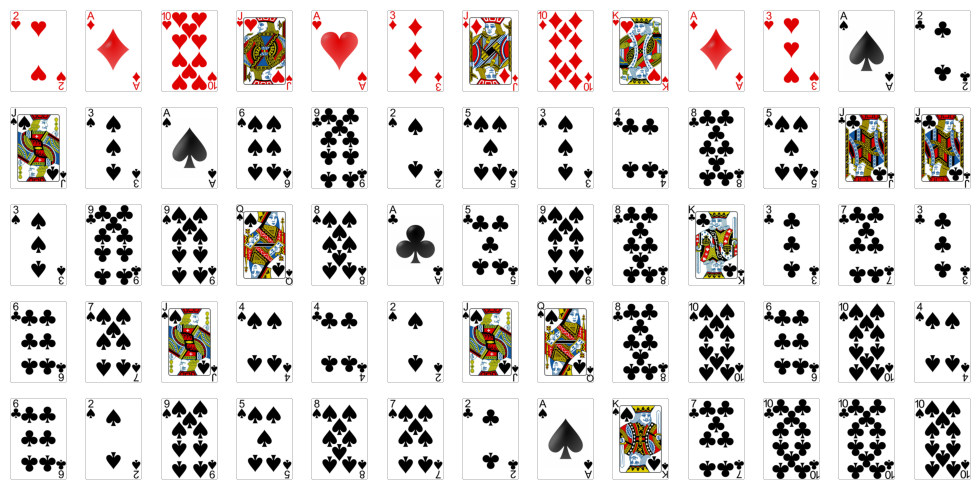

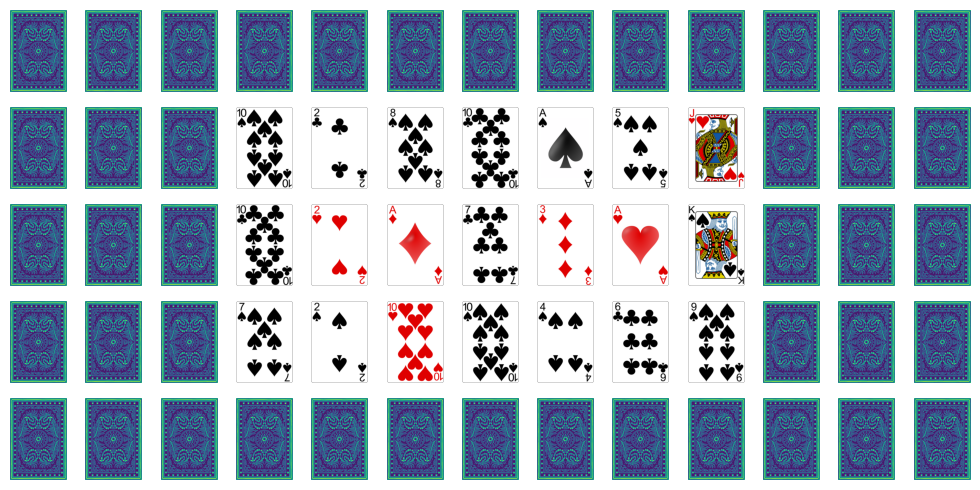

id                                                        601
batch                                                    game
stimulus    [[img/img_card_back.png, img/img_card_back.png...
cards       [img/4_of_hearts.png, img/10_of_diamonds.png, ...
nr_reds                                                    42
nr_total                                                   65
AI_reds                                                     7
AI_total                                                   13
AI_conf                                                    54
Name: 601, dtype: object


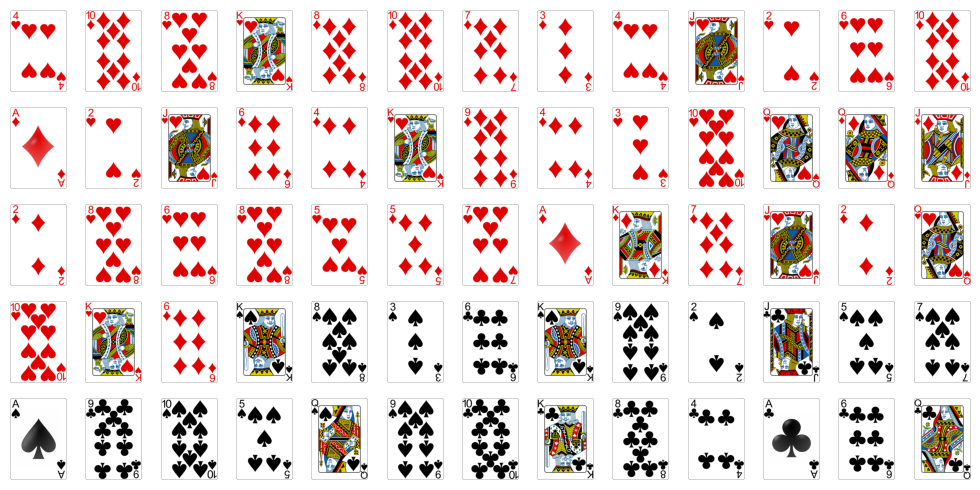

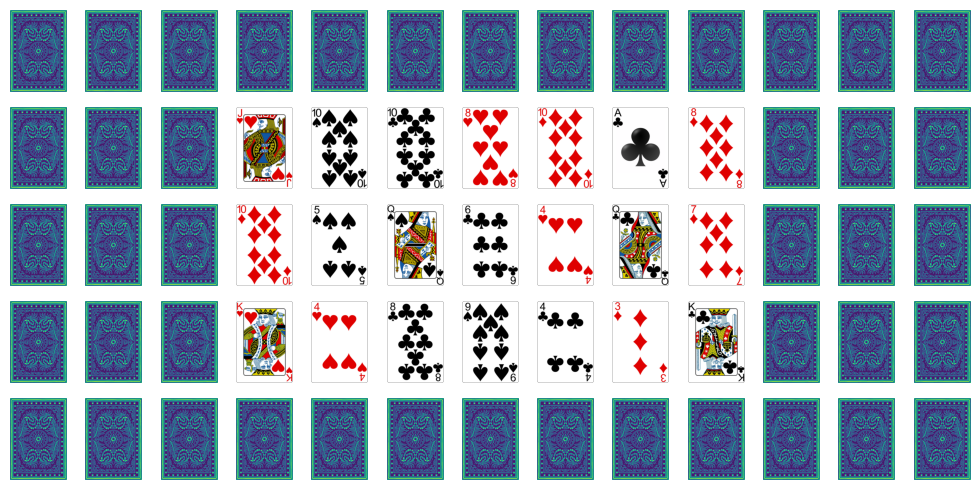

id                                                        601
batch                                                    game
stimulus    [[img/img_card_back.png, img/img_card_back.png...
cards       [img/4_of_hearts.png, img/ace_of_hearts.png, i...
nr_reds                                                    23
nr_total                                                   65
AI_reds                                                     6
AI_total                                                   13
AI_conf                                                    46
Name: 601, dtype: object


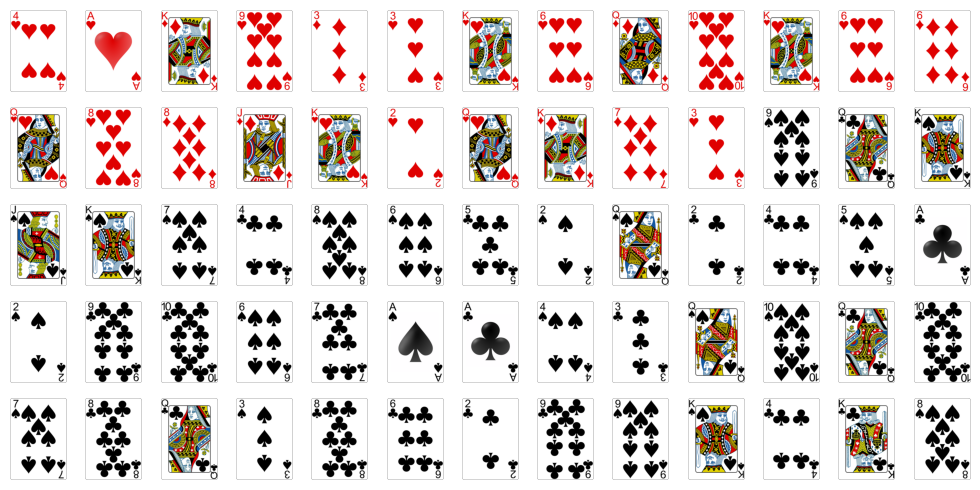

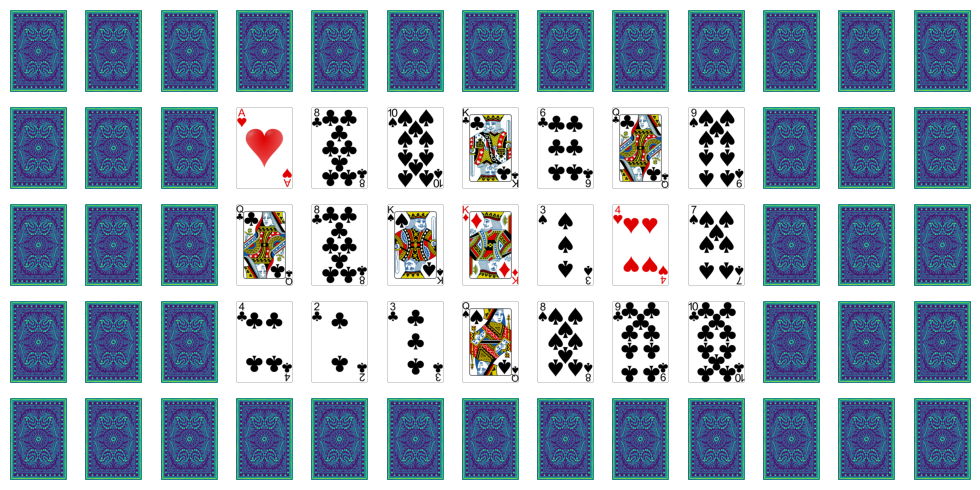

In [102]:
print(df_hard.loc[601])
show_grid(np.array(df_hard.loc[601,"cards"]).tolist())
show_grid(np.array(df_hard.loc[601,"stimulus"]).flatten().tolist())

print(df_random.loc[601])
show_grid(np.array(df_random.loc[601,"cards"]).tolist())
show_grid(np.array(df_random.loc[601,"stimulus"]).flatten().tolist())

print(df_easy.loc[601])
show_grid(np.array(df_easy.loc[601,"cards"]).tolist())
show_grid(np.array(df_easy.loc[601,"stimulus"]).flatten().tolist())

### Plot distribution of instances ###

Probability per AI confidence (bin): 
0    0.209
1    0.089
2    0.100
3    0.102
4    0.094
5    0.097
6    0.102
7    0.104
8    0.103
Name: true_prob, dtype: float64


Text(0, 0.5, 'AI confidence')

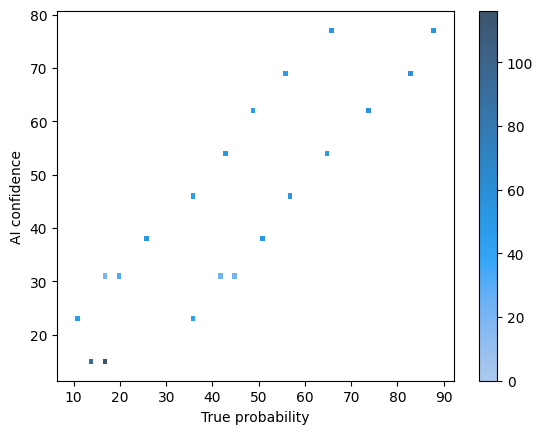

In [103]:
df_hard["true_prob"] = df_hard["nr_reds"]/df_hard["nr_total"]*100

df = df_hard[["true_prob","AI_conf"]].copy()
print("Probability per AI confidence (bin): ")
print(df.groupby(["AI_conf"], as_index=False).count()["true_prob"]/df.shape[0])
ax = sns.histplot(df, x="true_prob", y="AI_conf", discrete=(True, True),  cbar='true' )

ax.set_xlabel("True probability")
ax.set_ylabel("AI confidence")

Probability per AI confidence (bin): 
0    0.112
1    0.101
2    0.098
3    0.128
4    0.104
5    0.107
6    0.140
7    0.100
8    0.110
Name: true_prob, dtype: float64


Text(0, 0.5, 'AI confidence')

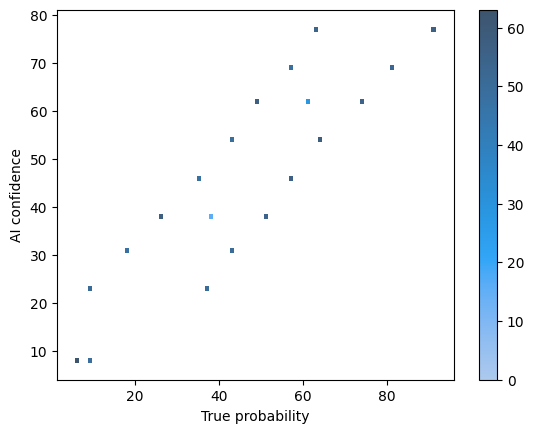

In [104]:
df_random["true_prob"] = df_random["nr_reds"]/df_random["nr_total"]*100

df = df_random[["true_prob","AI_conf"]].copy()
print("Probability per AI confidence (bin): ")
print(df.groupby(["AI_conf"], as_index=False).count()["true_prob"]/df.shape[0])
ax = sns.histplot(df, x="true_prob", y="AI_conf", discrete=(True, True),  cbar='true' )

ax.set_xlabel("True probability")
ax.set_ylabel("AI confidence")

Probability per AI confidence (bin): 
0    0.199
1    0.094
2    0.096
3    0.093
4    0.102
5    0.103
6    0.086
7    0.121
8    0.106
Name: true_prob, dtype: float64


Text(0, 0.5, 'AI confidence')

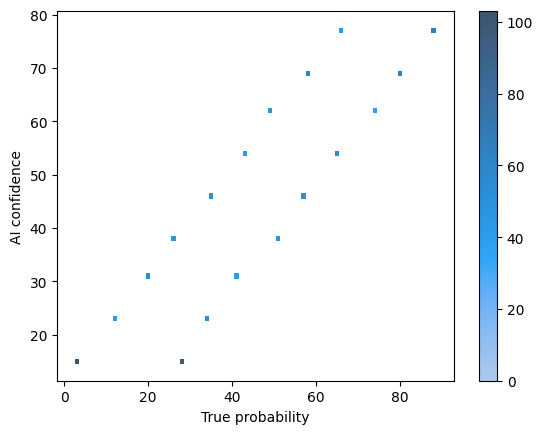

In [105]:
df_easy["true_prob"] = df_easy["nr_reds"]/df_easy["nr_total"]*100

df = df_easy[["true_prob","AI_conf"]].copy()
print("Probability per AI confidence (bin): ")
print(df.groupby(["AI_conf"], as_index=False).count()["true_prob"]/df.shape[0])
ax = sns.histplot(df, x="true_prob", y="AI_conf", discrete=(True, True),  cbar='true' )

ax.set_xlabel("True probability")
ax.set_ylabel("AI confidence")

### Calibration Metrics of AI ###

In [106]:
ece = df.groupby(by=['AI_conf'], as_index=False).mean()
print(ece)
print( "ECE:", abs(ece['AI_conf']-ece['true_prob']).mean()/100)
print( "MCE:", abs(ece['AI_conf']-ece['true_prob']).max()/100)

   AI_conf  true_prob
0       15  14.951681
1       23  24.451718
2       31  29.423077
3       38  38.593879
4       46  46.153846
5       54  54.996266
6       62  60.107335
7       69  69.319771
8       77  78.955007
ECE: 0.00998710579855195
MCE: 0.019550072568940494


### Get Perceived Probabilities ###

In [107]:
conf_levels = ["very low", "low", "high", "very high","very high"]

df_center_responses_hard = get_responses(stimuli_hard, attention) 
df_center_responses_hard = discretize_confidence(df_center_responses_hard, conf_levels) 
df_center_responses_hard["true_prob"] = df_center_responses_hard["nr_reds"]/df_center_responses_hard["nr_total"]*100

df_center_responses_random = get_responses(stimuli_random, attention)  
df_center_responses_random = discretize_confidence(df_center_responses_random, conf_levels)
df_center_responses_random["true_prob"] = df_center_responses_random["nr_reds"]/df_center_responses_random["nr_total"]*100

df_center_responses_easy = get_responses(stimuli_easy, attention)  
df_center_responses_easy = discretize_confidence(df_center_responses_easy, conf_levels)
df_center_responses_easy["true_prob"] = df_center_responses_easy["nr_reds"]/df_center_responses_easy["nr_total"]*100

### Expected Utility ###

In [149]:
def plot_point_distribution(df_utility, sample):
    sample_list =[]
    for s in sample:
        df_sample = df_utility.loc[s].copy()
        df_sample["outcome"] = df_sample.apply(lambda x: np.random.choice([True, False], size=1, p=[x["true_prob"]/100, 1-x["true_prob"]/100]), axis=1 )
        util_max = df_sample.apply(lambda x: -1 if x["Decision Human+AI max"]!= x["outcome"] else 1 if x["Decision Human"]!= x["outcome"] else 2, axis=1).sum()
        util_min = df_sample.apply(lambda x: -1 if x["Decision Human+AI min"]!= x["outcome"] else 1 if x["Decision Human"]!= x["outcome"] else 2, axis=1).sum()
        util = df_sample.apply(lambda x: -1 if x["Decision Human+AI"]!= x["outcome"] else 1 if x["Decision Human"]!= x["outcome"] else 2, axis=1).sum()

        sample_list.append({ "Points Human+AI": util, "Points Human+AI max": util_max, "Points Human+AI min": util_min})

    df = pd.DataFrame(sample_list)
    # print(df)
    fig, axes = plt.subplots(1,3, figsize=(13, 4))
    sns.histplot(data=df, x="Points Human+AI", discrete=True, stat="count",  kde=True, legend=True, ax=axes[0])
    sns.histplot(data=df, x="Points Human+AI max", discrete=True, stat="count",  kde=True, legend=True, ax=axes[1])
    sns.histplot(data=df, x="Points Human+AI min", discrete=True, stat="count",  kde=True, legend=True, ax=axes[2])

    print("Points Human+AI: ", df["Points Human+AI"].mean())
    print("Points Human+AI max: ", df["Points Human+AI max"].mean())
    print("Points Human+AI min: ", df["Points Human+AI min"].mean())

In [168]:
def plot_point_distribution(df_utility, sample):
    sample_list =[]
    for s in sample:
        df_sample = df_utility.loc[s].copy()
        df_sample["outcome"] = df_sample.apply(lambda x: np.random.choice([True, False], size=1, p=[x["true_prob"]/100, 1-x["true_prob"]/100]), axis=1 )
        util_max = df_sample.apply(lambda x: -1 if x["Decision Human+AI max"]!= x["outcome"] else 1 , axis=1).sum()
        util_min = df_sample.apply(lambda x: -1 if x["Decision Human+AI min"]!= x["outcome"] else 1 , axis=1).sum()
        util = df_sample.apply(lambda x: -1 if x["Decision Human+AI"]!= x["outcome"] else 1 , axis=1).sum()
        util_human = df_sample.apply(lambda x: -1 if x["Decision Human"]!= x["outcome"] else 1 , axis=1).sum()

        sample_list.append({ "Points Human+AI": util, "Points Human+AI max": util_max, "Points Human+AI min": util_min, "Points Human": util_human})

    df = pd.DataFrame(sample_list)
    # print(df)
    fig, axes = plt.subplots(1,4, figsize=(18, 4))
    sns.histplot(data=df, x="Points Human", discrete=True, stat="count",  kde=True, legend=True, ax=axes[0])
    sns.histplot(data=df, x="Points Human+AI", discrete=True, stat="count",  kde=True, legend=True, ax=axes[1])
    sns.histplot(data=df, x="Points Human+AI max", discrete=True, stat="count",  kde=True, legend=True, ax=axes[2])
    sns.histplot(data=df, x="Points Human+AI min", discrete=True, stat="count",  kde=True, legend=True, ax=axes[3])

    print("Points Human: ", df["Points Human"].mean()*0.10)
    print("Points Human+AI: ", df["Points Human+AI"].mean()*0.10)
    print("Points Human+AI max: ", df["Points Human+AI max"].mean()*0.10)
    print("Points Human+AI min: ", df["Points Human+AI min"].mean()*0.10)

In [166]:

def compute_utility(df_utility, decision_maker, prob_name, sample, compute_prob=False):
    if compute_prob:
        df_helper = df_utility.pivot_table(
                        columns=[prob_name,'AI_conf'], aggfunc='mean', values="true_prob",dropna=False).unstack().reset_index().fillna(value=0).rename(columns={0:'Prob '+decision_maker})
        #drop column level_2
        df_helper.drop("level_2", inplace=True, axis=1)
        # df_utility = df_utility.merge(df_helper, on=[prob_name,"AI_conf"], how='inner')
        df_utility = df_utility.join(df_helper.set_index([prob_name,"AI_conf"]), on=[prob_name,"AI_conf"])
        prob_name = "Prob "+decision_maker
    
    df_utility["Decision "+ decision_maker] = df_utility[prob_name]>50
    # df_utility.loc[df_utility[prob_name]==50, [decision_maker]] = np.random.choice([True, False], len(df_utility.loc[df_utility[prob_name]==50]))
    
    df_utility["Utility "+ decision_maker] = df_utility["Decision "+ decision_maker]*df_utility["true_prob"] + (1-df_utility["Decision "+ decision_maker])*(100-df_utility["true_prob"])
    
    print("Utility "+ decision_maker+": ", df_utility["Utility "+ decision_maker].mean())
    # print("Utility "+ decision_maker+" sample: ", df_utility.loc[sample,"Utility "+ decision_maker].mean())
    # print("Utility "+ decision_maker+" sample std: ", df_utility.loc[sample,"Utility "+ decision_maker].std())

    dm_performance = np.array([df_utility.loc[s,"Utility "+ decision_maker].sum() for s in sample])
    print("Utility "+ decision_maker+" sample: ", dm_performance.mean())
    print("Utility "+ decision_maker+" sample std: ", dm_performance.std())

    if compute_prob:
        df_utility["Decision "+ decision_maker+" max"] = df_utility.apply(lambda x: df_utility[ df_utility["AI_conf"]==x["AI_conf"]]["Decision "+ decision_maker ].max() , axis=1)
        df_utility["Decision "+ decision_maker+" min"] = df_utility.apply(lambda x: df_utility[ (df_utility["AI_conf"]==x["AI_conf"]) & (df_utility[prob_name]!=0)]["Decision "+ decision_maker ].min() , axis=1)

        df_utility["Utility "+ decision_maker +" max"] = df_utility["Decision "+ decision_maker+" max"]*df_utility["true_prob"] + (1-df_utility["Decision "+ decision_maker+" max"])*(100-df_utility["true_prob"])
        df_utility["Utility "+ decision_maker + " min"] = df_utility["Decision "+ decision_maker+" min"]*df_utility["true_prob"] + (1-df_utility["Decision "+ decision_maker+" min"])*(100-df_utility["true_prob"])

        print("Utility "+ decision_maker+" max: ", df_utility["Utility "+ decision_maker+" max"].mean())
        print("Utility "+ decision_maker+" min: ", df_utility["Utility "+ decision_maker+" min"].mean())
        # print("Utility "+ decision_maker+" sample max: ", df_utility.loc[sample,"Utility "+ decision_maker+" max"].mean())
        # print("Utility "+ decision_maker+" sample min: ", df_utility.loc[sample,"Utility "+ decision_maker+" min"].mean())

        dm_performance = np.array([df_utility.loc[s,"Utility "+ decision_maker+" max"].sum() for s in sample])
        # print(dm_performance)
        print("Utility "+ decision_maker+" max sample: ", dm_performance.mean())
        print("Utility "+ decision_maker+" max sample std: ", dm_performance.std())

        dm_performance = np.array([df_utility.loc[s,"Utility "+ decision_maker+" min"].sum() for s in sample])
        # print(dm_performance)
        print("Utility "+ decision_maker+" min sample: ", dm_performance.mean())
        print("Utility "+ decision_maker+" min sample std: ", dm_performance.std())

        exp_points = (df_utility["Utility Human"].mean()/100 + df_utility["Utility Human+AI"].mean()/100 - (1- df_utility["Utility Human+AI"].mean()/100))* 20
        util = max(df_utility["Utility Human+AI max"].mean()/100, df_utility["Utility Human+AI min"].mean()/100,)
        exp_points2 = (df_utility["Utility Human"].mean()/100 + util - (1- util))* 20
        # exp_points_sample = np.array([(df_utility.loc[s,"Utility Human"].mean()/100 + df_utility.loc[s,"Utility Human+AI"].mean()/100 - (1- df_utility.loc[s,"Utility Human+AI"].mean()/100))* 20 for s in sample])
        # exp_points2_sample = np.array([(df_utility.loc[s,"Utility Human"].mean()/100 + max(df_utility.loc[s,"Utility Human+AI max"].mean()/100,  df_utility.loc[s,"Utility Human+AI min"].mean()/100) - (1- max(df_utility.loc[s,"Utility Human+AI max"].mean()/100,  df_utility.loc[s,"Utility Human+AI min"].mean()/100)))* 20 for s in sample])
        print("Expected Points in Game: ", exp_points )
        # print("Expected Points in Game sample: ", exp_points_sample.mean() )
        # print("Expected Points in Game sample: ", exp_points_sample.std() )
        print("Expected Reward in Game: ", exp_points*0.04 )
        print("Expected Points in Game min/max: ", exp_points2 )
        # print("Expected Points in Game min/max sample: ", exp_points2_sample.mean() )
        # print("Expected Points in Game min/max sample: ", exp_points2_sample.std() )
        print("Expected Reward in Game min/max: ", exp_points2*0.04 )
        print()

    
        plot_point_distribution(df_utility,sample)
    

def estimated_utility(stimuli):
    df_utility = stimuli[["dm_conf","AI_conf","center_prob","true_prob"]].copy()
    
    # sample = np.random.choice(df_utility.index, 17)
    # for i in range(100):
    #     sample = np.concatenate((sample, np.random.choice(df_utility.index, 17)))

    sample = []
    for i in range(100):
        sample += [ np.random.choice(df_utility.index, 17)]
        
    compute_utility(df_utility, "Best", "true_prob", sample, compute_prob=False)
    compute_utility(df_utility, "AI", "AI_conf", sample, compute_prob=False)
    compute_utility(df_utility, "Human", "center_prob", sample, compute_prob=False)
    compute_utility(df_utility, "Human+AI", "dm_conf", sample, compute_prob=True)
    # compute_utility(df_utility, "Human+AI nondiscrete", "center_prob", sample, compute_prob=True)



Level Hard
Utility Best:  71.25804474410053
Utility Best sample:  1224.9846153846154
Utility Best sample std:  61.9990914230048
Utility AI:  69.74410052099296
Utility AI sample:  1200.876923076923
Utility AI sample std:  71.39298856728195
Utility Human:  62.83021759117377
Utility Human sample:  1076.6923076923076
Utility Human sample std:  96.12993548859492
Utility Human+AI:  71.06497088568801
Utility Human+AI sample:  1221.7846153846156
Utility Human+AI sample std:  64.26082944674332
Utility Human+AI max:  66.76371437327614
Utility Human+AI min:  66.4222716465983
Utility Human+AI max sample:  1148.5846153846155
Utility Human+AI max sample std:  81.58784571274903
Utility Human+AI min sample:  1141.4153846153847
Utility Human+AI min sample std:  82.91313769461912
Expected Points in Game:  20.992031872509962
Expected Reward in Game:  4.198406374501992
Expected Points in Game min/max:  19.27152926754521
Expected Reward in Game min/max:  3.8543058535090418

Points Human:  0.727499999999999

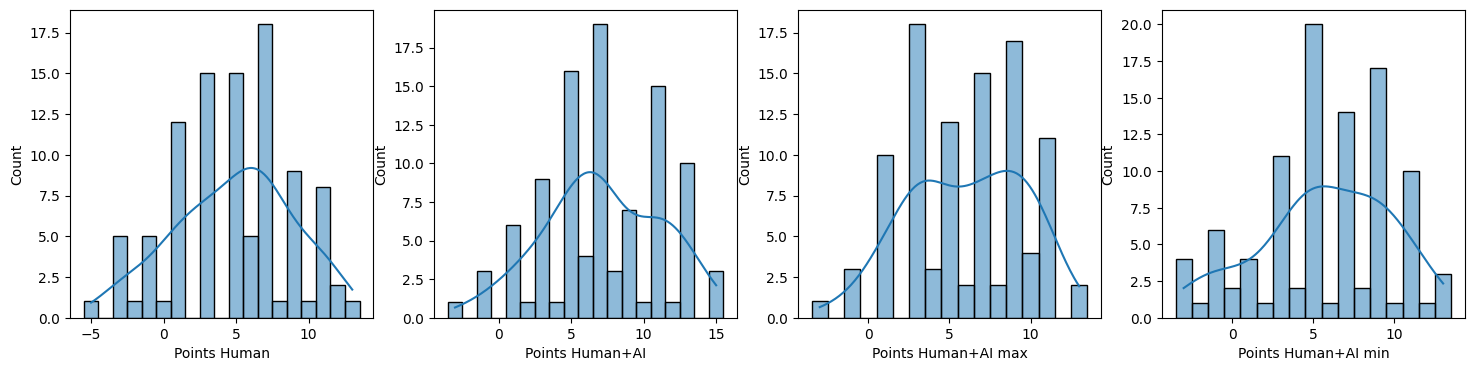

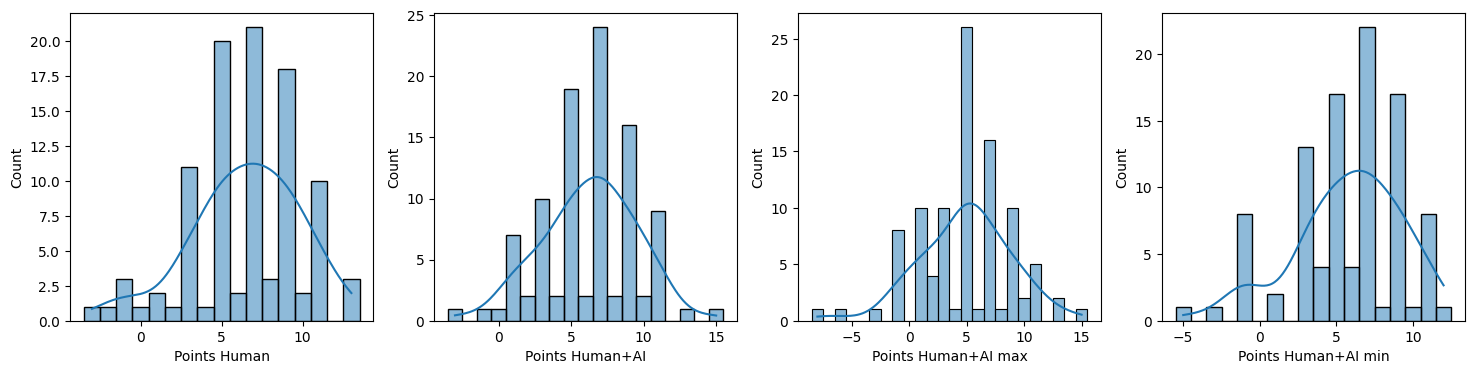

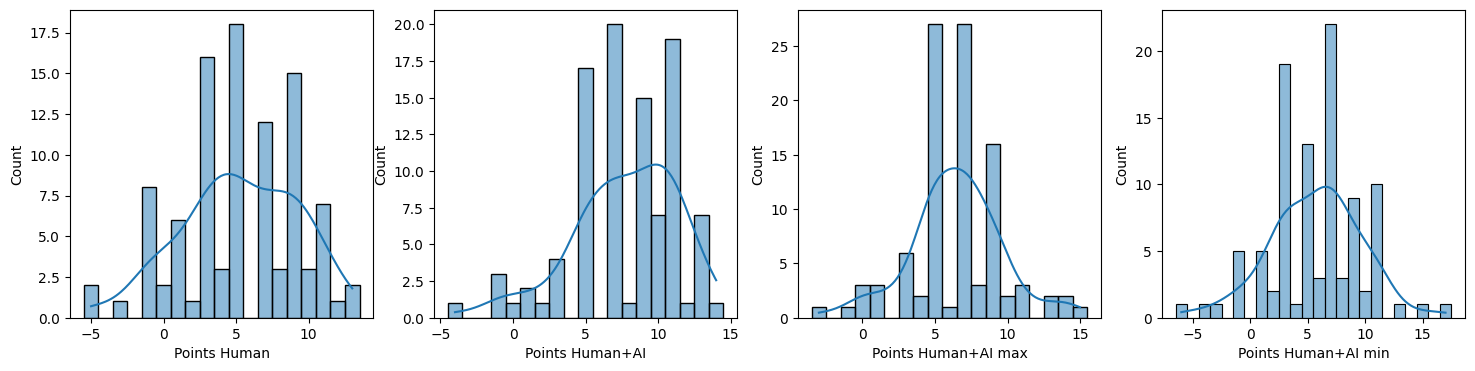

In [169]:
print("Level Hard")
estimated_utility(df_center_responses_hard)

print("Level Random")
estimated_utility(df_center_responses_random)

print("Level Easy")
estimated_utility(df_center_responses_easy)

### Alignemnt and Stripplots for Hard Level ###

/Users/ninacobe/Library/Python/3.8/lib/python/site-packages/seaborn/_statistics.py:486: RuntimeWarning: Mean of empty slice
  estimate = self.estimator(vals)


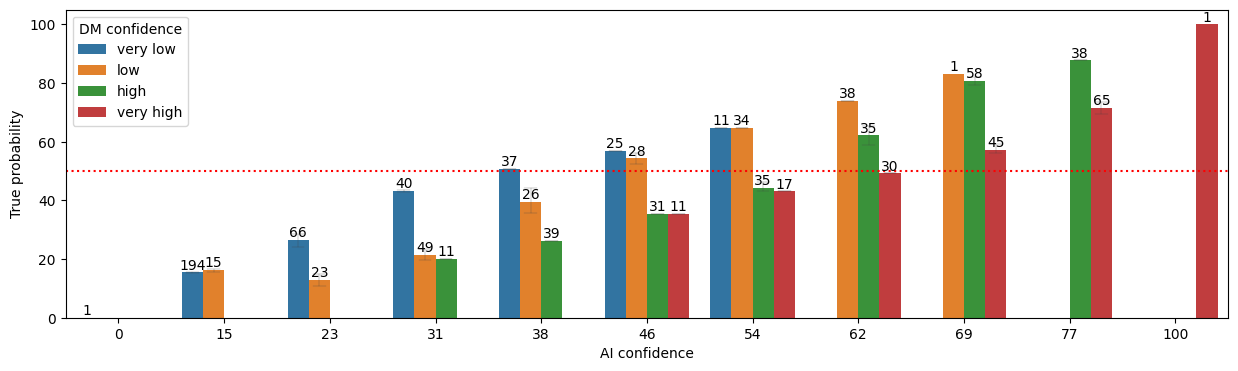

no red or black


/var/folders/vn/npqqxb9n14x_h_2r2gxx6gth0000gq/T/ipykernel_58698/2909325349.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Center Probability"])


no red or black
no red or black


/var/folders/vn/npqqxb9n14x_h_2r2gxx6gth0000gq/T/ipykernel_58698/2909325349.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Center Probability"])
/var/folders/vn/npqqxb9n14x_h_2r2gxx6gth0000gq/T/ipykernel_58698/2909325349.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Center Probability"])


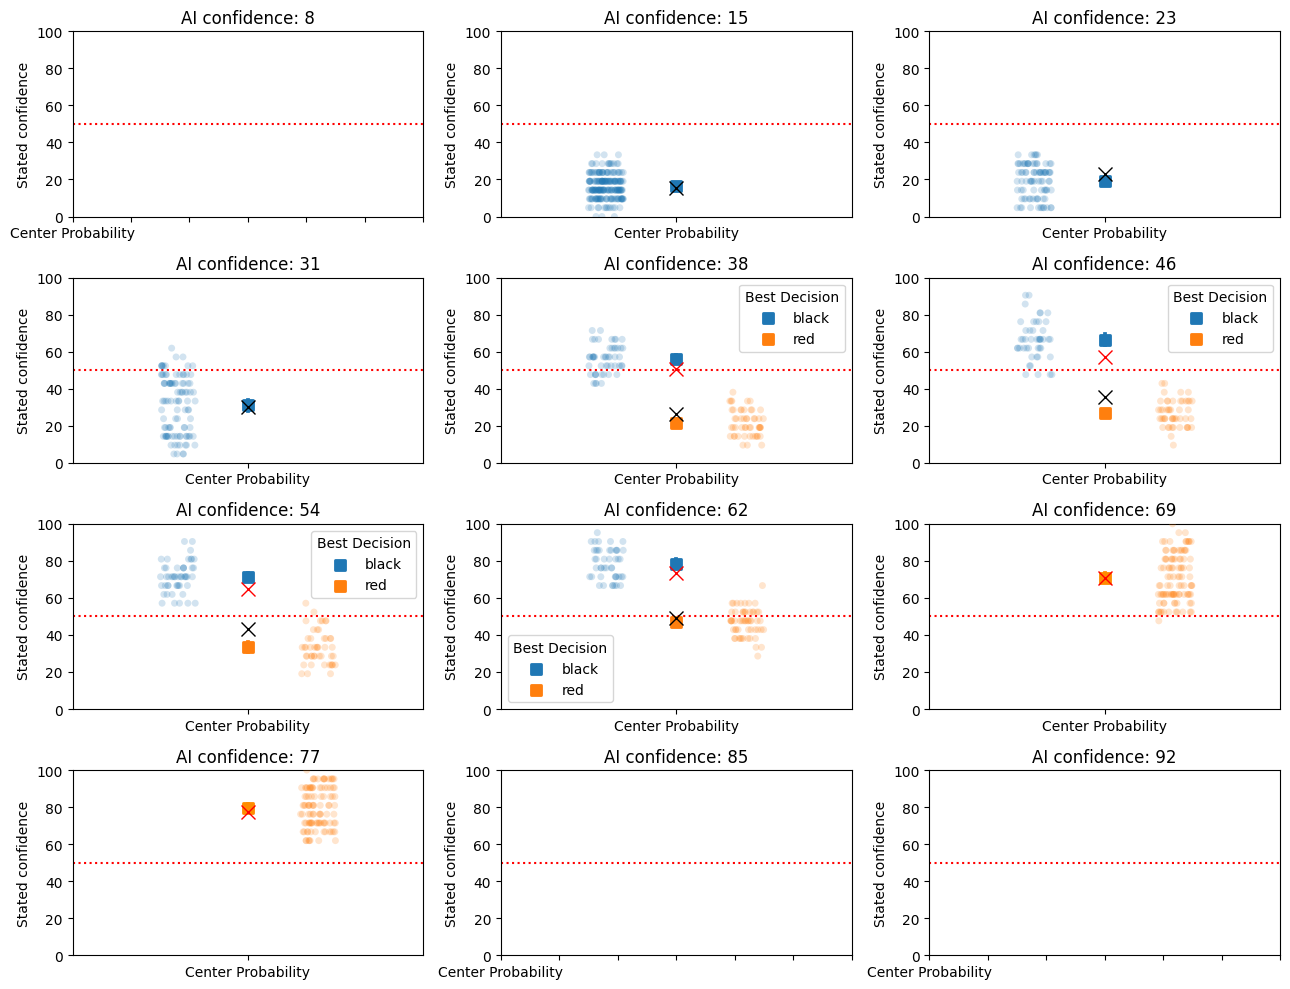

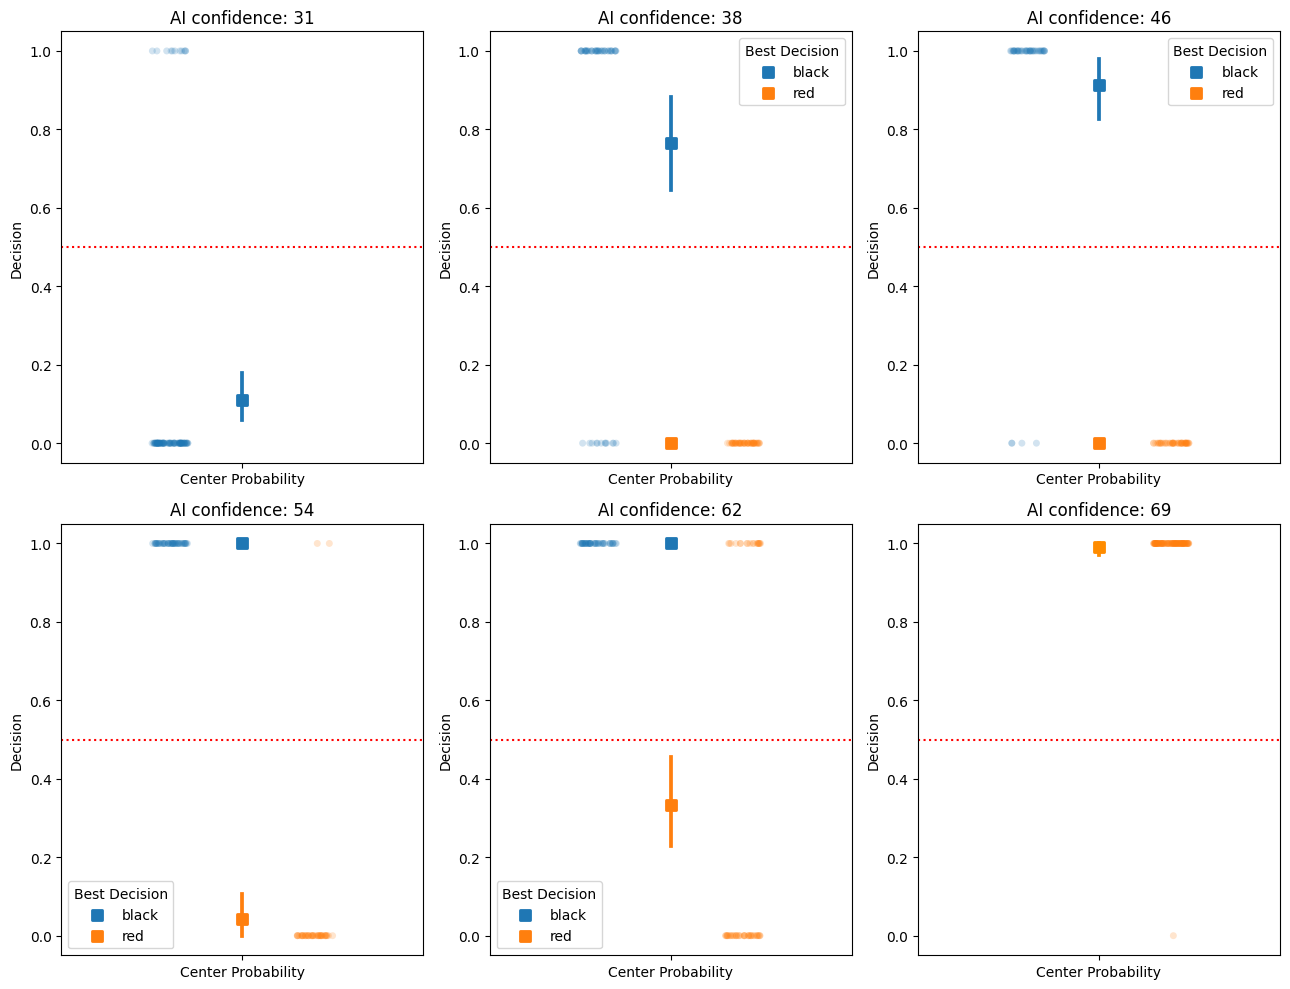

In [110]:
# conf_levels = ["very low", "low", "high", "very high","very high"]

# df_center_responses_hard = discretize_confidence(df_center_responses_hard, conf_levels)
alignment_plot(df_center_responses_hard, conf_levels[0:4])
stripplot(df_center_responses_hard)
stripplot_decision(df_center_responses_hard)

/Users/ninacobe/Library/Python/3.8/lib/python/site-packages/seaborn/_statistics.py:486: RuntimeWarning: Mean of empty slice
  estimate = self.estimator(vals)


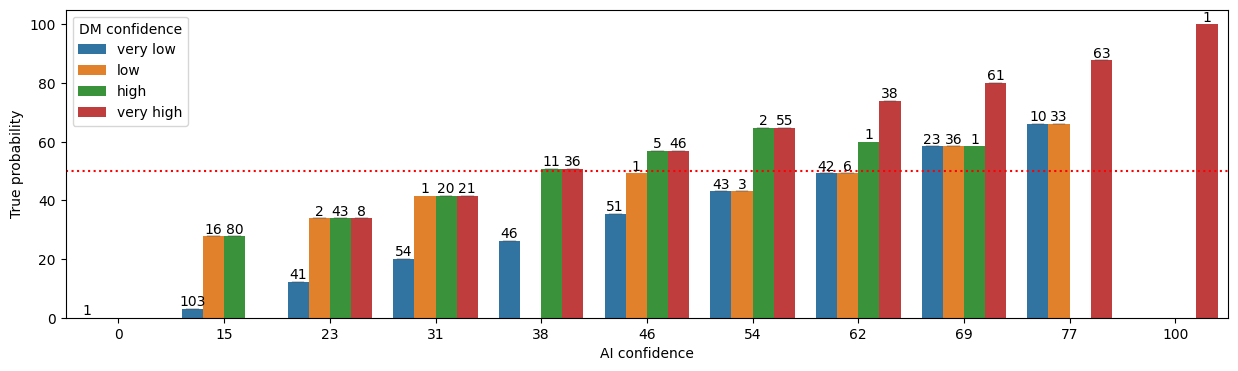

no red or black


/var/folders/vn/npqqxb9n14x_h_2r2gxx6gth0000gq/T/ipykernel_58698/2909325349.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Center Probability"])


no red or black
no red or black


/var/folders/vn/npqqxb9n14x_h_2r2gxx6gth0000gq/T/ipykernel_58698/2909325349.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Center Probability"])
/var/folders/vn/npqqxb9n14x_h_2r2gxx6gth0000gq/T/ipykernel_58698/2909325349.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Center Probability"])


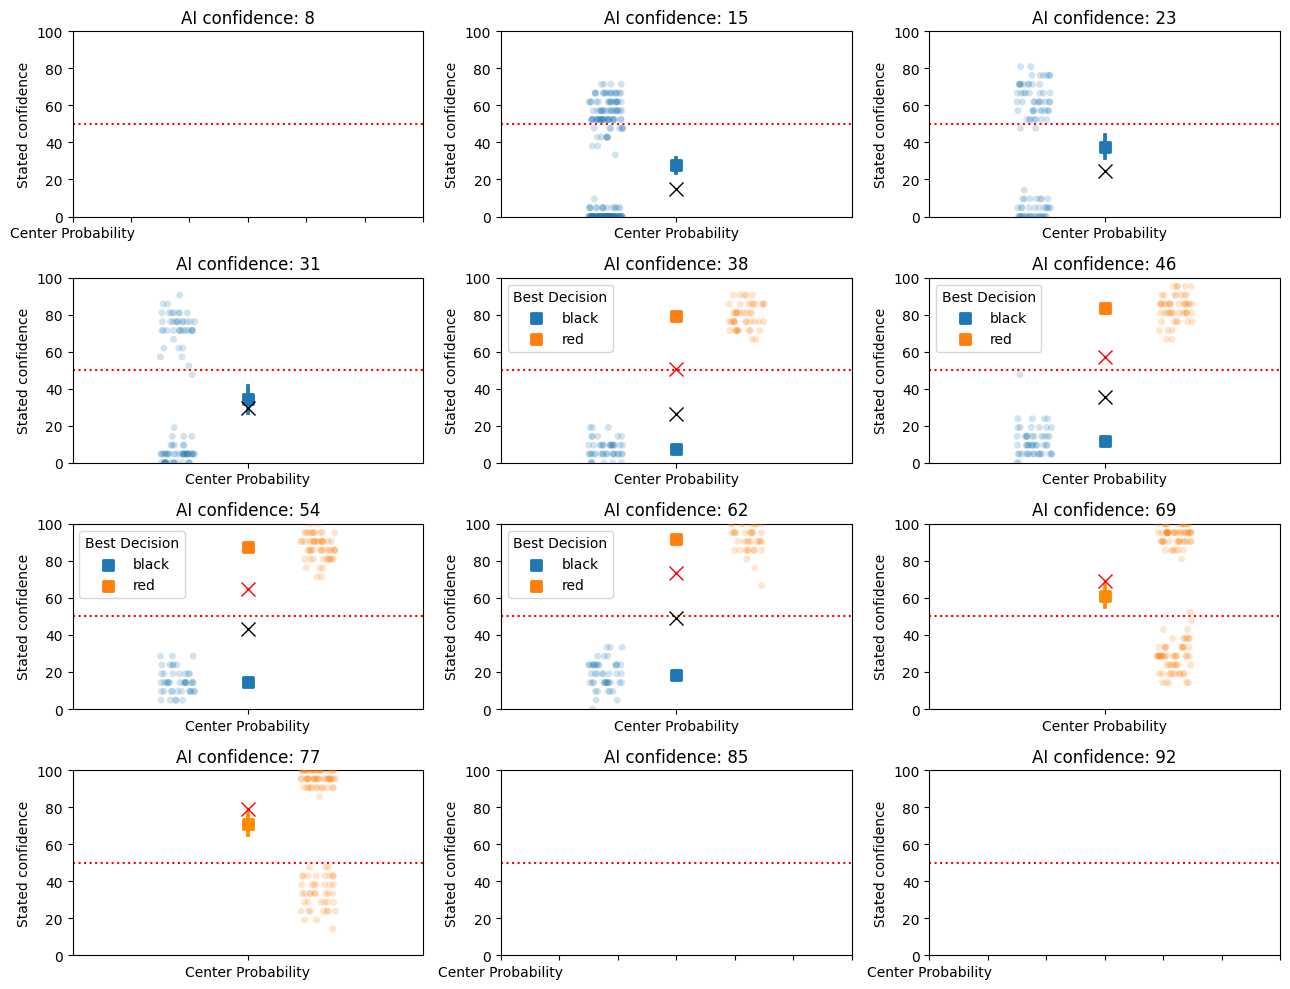

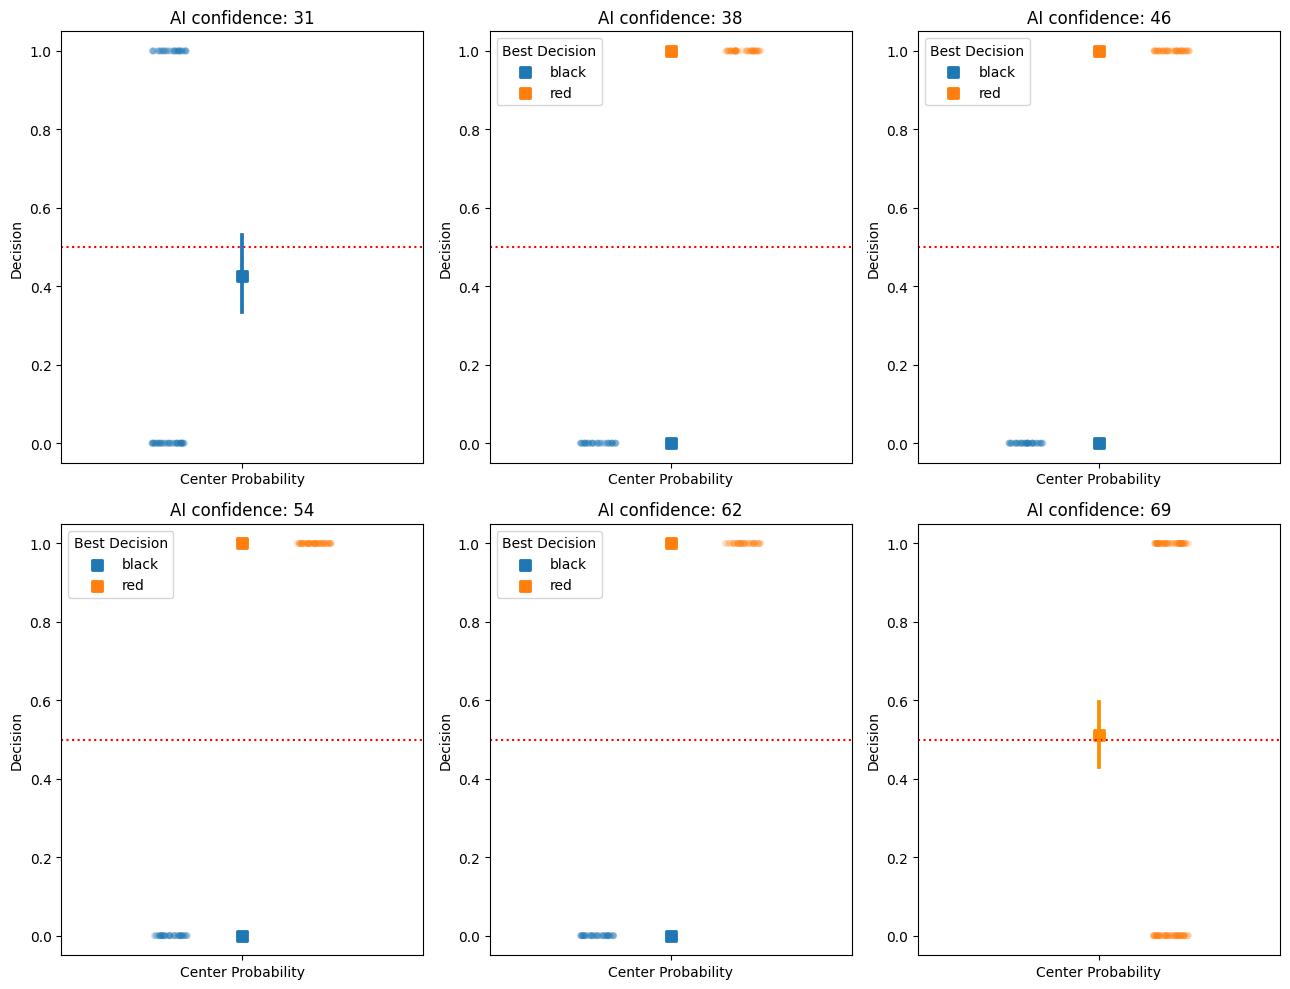

In [111]:
# conf_levels = ["very low", "low", "high", "very high","very high"]

# df_center_responses_easy = discretize_confidence(df_center_responses_easy, conf_levels)
alignment_plot(df_center_responses_easy, conf_levels[0:4])
stripplot(df_center_responses_easy)
stripplot_decision(df_center_responses_easy)

/Users/ninacobe/Library/Python/3.8/lib/python/site-packages/seaborn/_statistics.py:486: RuntimeWarning: Mean of empty slice
  estimate = self.estimator(vals)


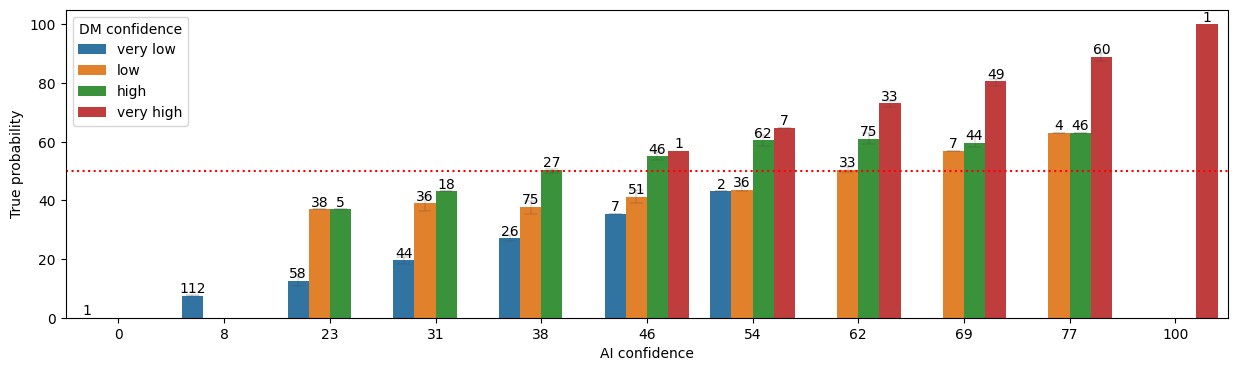

no red or black


/var/folders/vn/npqqxb9n14x_h_2r2gxx6gth0000gq/T/ipykernel_58698/2909325349.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Center Probability"])


no red or black
no red or black


/var/folders/vn/npqqxb9n14x_h_2r2gxx6gth0000gq/T/ipykernel_58698/2909325349.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Center Probability"])
/var/folders/vn/npqqxb9n14x_h_2r2gxx6gth0000gq/T/ipykernel_58698/2909325349.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Center Probability"])


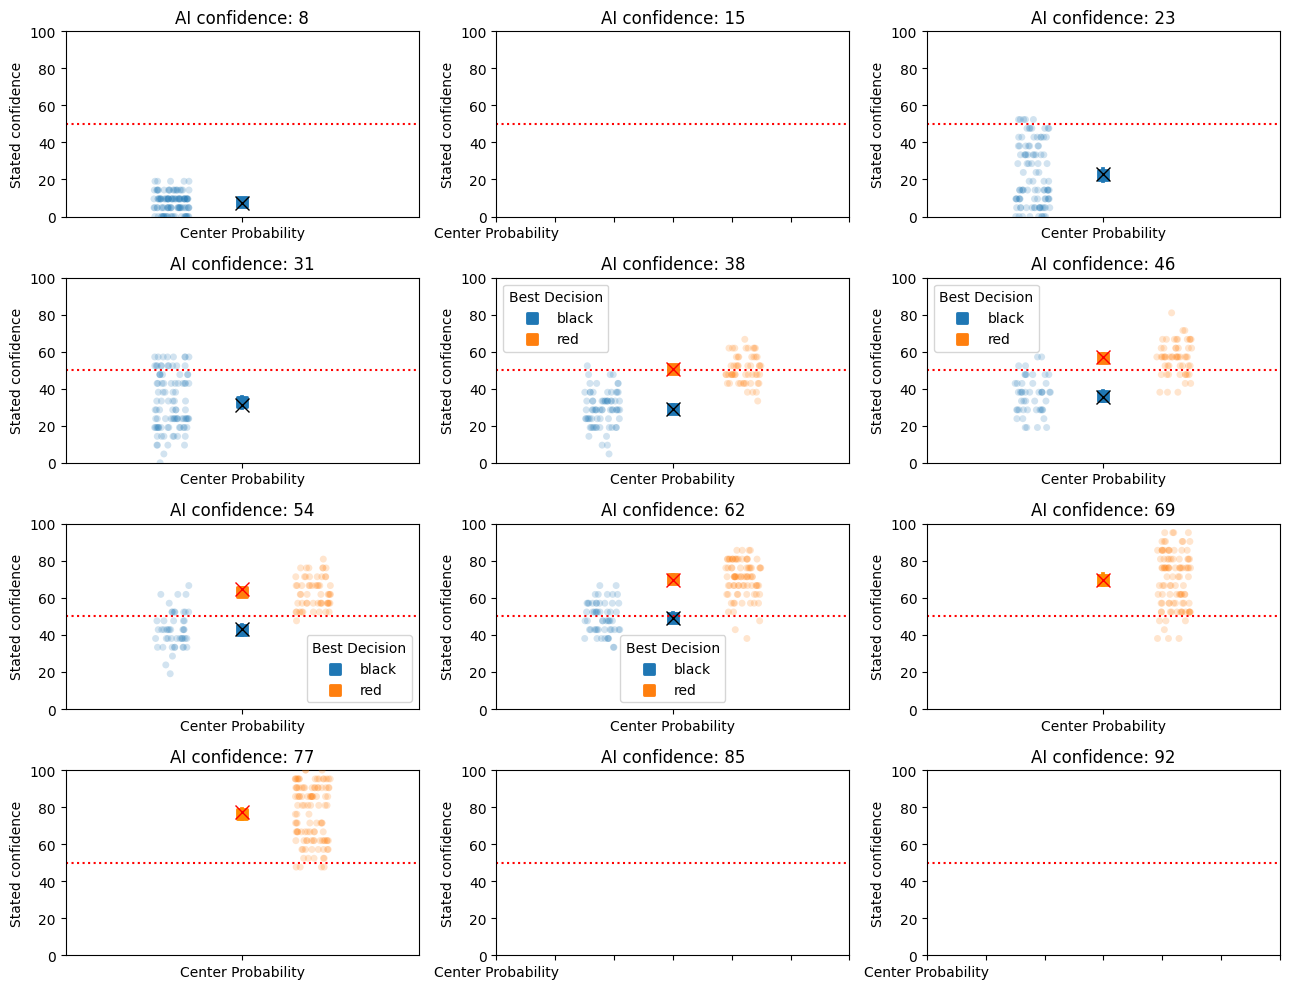

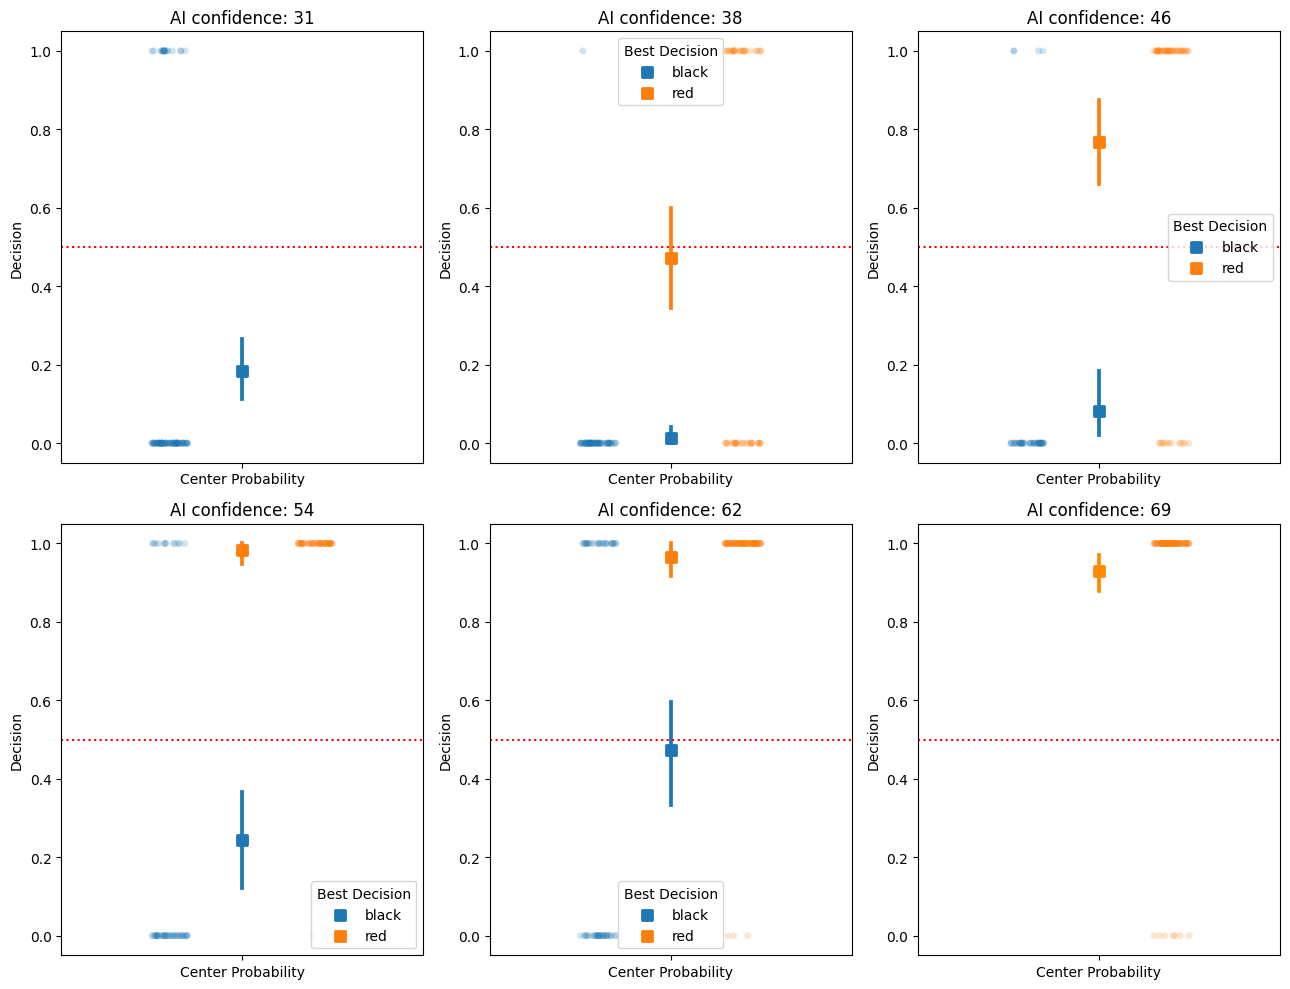

In [112]:
# conf_levels = ["very low", "low", "high", "very high","very high"]

# df_center_responses_random = discretize_confidence(df_center_responses_random, conf_levels)
alignment_plot(df_center_responses_random, conf_levels[0:4])
stripplot(df_center_responses_random)
stripplot_decision(df_center_responses_random)

In [113]:
df_center_responses_hard

,id,batch,stimulus,cards,nr_reds,nr_total,AI_reds,AI_total,AI_conf,center_prob,dm_conf,true_prob,index
0,0,game,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...","[img/2_of_hearts.png, img/10_of_hearts.png, im...",27,65,4,13,31,9.523810,very low,41.538462,0
1,1,game,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...","[img/2_of_diamonds.png, img/5_of_hearts.png, i...",23,65,6,13,46,76.190476,very high,35.384615,1
2,2,game,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...","[img/7_of_diamonds.png, img/8_of_diamonds.png,...",11,65,2,13,15,14.285714,very low,16.923077,2
3,3,game,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...","[img/5_of_hearts.png, img/queen_of_diamonds2.p...",36,65,9,13,69,71.428571,high,55.384615,3
4,4,game,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...","[img/ace_of_hearts.png, img/ace_of_diamonds.pn...",9,65,2,13,15,14.285714,very low,13.846154,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,999,game,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...","[img/4_of_hearts.png, img/6_of_diamonds.png, i...",29,65,4,13,31,4.761905,very low,44.615385,999
0,-1,attention,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...","[img/king_of_hearts2.png, img/4_of_hearts.png,...",65,65,13,13,100,100.000000,very high,100.000000,0
1,-2,attention,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...","[img/5_of_spades.png, img/ace_of_spades2.png, ...",0,65,0,13,0,0.000000,very low,0.000000,1
2,-3,attention,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...","[img/8_of_hearts.png, img/7_of_hearts.png, img...",39,65,8,13,62,66.666667,high,60.000000,2


In [114]:
from scipy.stats import hypergeom, nchypergeom_wallenius

# # x= nchypergeom_wallenius.cdf(10, 52, 20, 20, odds=1/9)
# # x2= nchypergeom_wallenius.cdf(15, 52, 20, 20, odds=9)
# for r in range(0,52):
#     # print(hypergeom.cdf(10, 52, r, 20))
#     # print(hypergeom.cdf(9, 52, r, 20)+ (1-hypergeom.cdf(10, 52, r, 20)) + hypergeom.pmf(10, 52, r, 20) )
#     print(nchypergeom_wallenius.cdf(9, 52, r, 20, odds=1/4) )
#     print(nchypergeom_wallenius.cdf(9, 65, r, 20, odds=1/4) )

print(1-nchypergeom_wallenius.cdf(10, 65, 35, 21, odds=1/4) )
print(1-nchypergeom_wallenius.cdf(10, 65, 30, 21, odds=4/1) )
# (1-nchypergeom_wallenius.cdf(10, 52, x["true_reds"], 20, odds=x["bias_hard"]))

0.0035775177593624363
0.9964224822406375
